# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs

## Lab 0: Plant Seedlings Classification (PyTorch): The most basic lab :)  

<img src="../assets/seedlings.png" align="center">

### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="../assets/pt.jpg" width="35%" align="center">

### Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924

### Date and Location: 
- July 2018


### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


### Training with TensorBoard

With the aid of [Crayon](https://github.com/torrvision/crayon),
we can access the visualisation power of TensorBoard for any 
deep learning framework.

To use the TensorBoard, install Crayon (https://github.com/torrvision/crayon)
and set `use_tensorboard = True`

In [11]:
%reset -f 
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.2.1+a4fc05a
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: None
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


### Define Custom Dataset

In [12]:
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
#         print (labels)
        if self.transform:
            image = self.transform(image)
        return image, labels
    

import os


data_dir= 'd:/db/data/bone/train/'
data_dir= 'd:/db/data/cat-dog/train/'
data_dir= 'd:/db/data/seedings/train/'

def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))
    
    train = []
    for index, label in enumerate(classes):
        path = fullDir + label + '/'
        for file in listdir(path):
            train.append(['{}/{}'.format(label, file), label, index])
    
    df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 

    return classes, class_to_idx, num_to_class, df

classes, class_to_idx, num_to_class, df =find_classes (data_dir )


# class_to_idx
# num_to_class
df.head(5)    

,file,category,category_id
0,Black-grass/0050f38b3.png,Black-grass,0
1,Black-grass/0183fdf68.png,Black-grass,0
2,Black-grass/0260cffa8.png,Black-grass,0
3,Black-grass/05eedce4d.png,Black-grass,0
4,Black-grass/075d004bc.png,Black-grass,0


In [13]:
len(classes)

12

# Augmentation 
- Many of the code snippts here were adapted from various github repos.
- If you dont need augementation, just skip this part.

In [14]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def draw(img, boxes):
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle(list(box), outline='red')
    img.show()


class Stack(object):

    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        if img_group[0].mode == 'L':
            return np.concatenate([np.expand_dims(x, 2) for x in img_group], axis=2)
        elif img_group[0].mode == 'RGB':
            if self.roll:
                return np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
            else:
                return np.concatenate(img_group, axis=2)


class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()


class IdentityTransform(object):

    def __call__(self, data):
        return data

class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size()[2] and h <= img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    #img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    #img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    # img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

def random_crop(img, boxes):
    '''Crop the given PIL image to a random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made.
    Args:
      img: (PIL.Image) image to be cropped.
      boxes: (tensor) object boxes, sized [#ojb,4].
    Returns:
      img: (PIL.Image) randomly cropped image.
      boxes: (tensor) randomly cropped boxes.
    '''
    success = False
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.56, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            success = True
            break

    # Fallback
    if not success:
        w = h = min(img.size[0], img.size[1])
        x = (img.size[0] - w) // 2
        y = (img.size[1] - h) // 2

    img = img.crop((x, y, x+w, y+h))
    boxes -= torch.Tensor([x,y,x,y])
    boxes[:,0::2].clamp_(min=0, max=w-1)
    boxes[:,1::2].clamp_(min=0, max=h-1)
    return img, boxes


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class Grayscale(object):
    def __call__(self, img):
        gs = img.clone()
        gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
        gs[1].copy_(gs[0])
        gs[2].copy_(gs[0])
        return gs


class Saturation(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Brightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = img.new().resize_as_(img).zero_()
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Contrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        gs.fill_(gs.mean())
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class RandomOrder(object):
    """ Composes several transforms together in random order.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        if self.transforms is None:
            return img
        order = torch.randperm(len(self.transforms))
        for i in order:
            img = self.transforms[i](img)
        return img


class ColorJitter(RandomOrder):
    def __init__(self, brightness=0.4, contrast=0.4, saturation=0.4):
        self.transforms = []
        if brightness != 0:
            self.transforms.append(Brightness(brightness))
        if contrast != 0:
            self.transforms.append(Contrast(contrast))
        if saturation != 0:
            self.transforms.append(Saturation(saturation))


class RandomFlip(object):
    """Randomly flips the given PIL.Image with a probability of 0.25 horizontal,
                                                                0.25 vertical,
                                                                0.5 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img.transpose(im.FLIP_LEFT_RIGHT),
            3: img.transpose(im.FLIP_TOP_BOTTOM)
        }

        return dispatcher[random.randint(0, 3)]  # randint is inclusive


class RandomRotate(object):
    """Randomly rotate the given PIL.Image with a probability of 1/6 90°,
                                                                 1/6 180°,
                                                                 1/6 270°,
                                                                 1/2 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img,
            3: img.transpose(im.ROTATE_90),
            4: img.transpose(im.ROTATE_180),
            5: img.transpose(im.ROTATE_270)
        }

        return dispatcher[random.randint(0, 5)]  # randint is inclusive


class PILColorBalance(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Color(img).enhance(alpha)


class PILContrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Contrast(img).enhance(alpha)


class PILBrightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Brightness(img).enhance(alpha)


class PILSharpness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Sharpness(img).enhance(alpha)


# Check ImageEnhancer effect: https://www.youtube.com/watch?v=_7iDTpTop04
# Not documented but all enhancements can go beyond 1.0 to 2
# Image must be RGB
# Use Pillow-SIMD because Pillow is too slow
class PowerPIL(RandomOrder):
    def __init__(self, rotate=True,
                 flip=True,
                 colorbalance=0.4,
                 contrast=0.4,
                 brightness=0.4,
                 sharpness=0.4):
        self.transforms = []
        if rotate:
            self.transforms.append(RandomRotate())
        if flip:
            self.transforms.append(RandomFlip())
        if brightness != 0:
            self.transforms.append(PILBrightness(brightness))
        if contrast != 0:
            self.transforms.append(PILContrast(contrast))
        if colorbalance != 0:
            self.transforms.append(PILColorBalance(colorbalance))
        if sharpness != 0:
            self.transforms.append(PILSharpness(sharpness))

def default_loader(input_path):
    input_image = (Image.open(input_path)).convert('RGB')
    return input_image


## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

In [24]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize_img
])

batch_size = 16
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = BoneDataset(train_data, data_dir, transform = train_trans)
valid_set = BoneDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}

print (dataset_sizes)

{'train': 4038, 'valid': 712}


### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


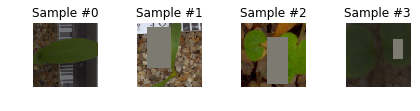

In [27]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np



dropout = torch.nn.Dropout(p=0.30)
relu=torch.nn.LeakyReLU()
pool = nn.MaxPool2d(2, 2)

class ConvRes(nn.Module):
    def __init__(self,insize, outsize):
        super(ConvRes, self).__init__()
        drate = .3
        self.math = nn.Sequential(
                 nn.BatchNorm2d(insize),
                 nn.Dropout(drate),
                 torch.nn.Conv2d(insize, outsize, kernel_size=2,padding=2),
                 nn.PReLU(),
                )
        
    def forward(self, x):
        return self.math(x) 

class ConvCNN(nn.Module):
    def __init__(self,insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg=avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size,padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool,pool),
        )
        self.avgpool=torch.nn.AvgPool2d(pool,pool)
        
    def forward(self, x):
        x=self.math(x)
        if self.avg is True:
            x=self.avgpool(x)
        return x   
        
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()        
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.cnn1 = ConvCNN (3,64,  kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN (64,64, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN (64,256, kernel_size=5, pool=2, avg=True)
        
        self.res1 = ConvRes (256,64)
        
        self.features = nn.Sequential( 
            self.cnn1,dropout,          
            self.cnn2,
            self.cnn3,
            self.res1,
        )        
        
        self.classifier = torch.nn.Sequential(
            nn.Linear(2304, len(classes)),             
        )
#         self.sig=nn.Sigmoid()        
            
    def forward(self, x):
        x = self.features(x) 
        x = x.view(x.size(0), -1)        
#         print (x.data.shape)
        x = self.classifier(x)                
#         x = self.sig(x)
        return x        

model = SimpleNet()
# model = senetXX_generic(1, 3, 16)
if use_cuda:
    model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.00005 * 2 * 2)

if use_cuda:
    model = model.cuda()
print (model)

SimpleNet (
  (avgpool): AdaptiveAvgPool2d (output_size=1)
  (cnn1): ConvCNN (
    (math): Sequential (
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (0.01)
      (3): MaxPool2d (size=(4, 4), stride=(4, 4), dilation=(1, 1))
    )
    (avgpool): AvgPool2d (size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN (
    (math): Sequential (
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (0.01)
      (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (avgpool): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN (
    (math): Sequential (
      (0): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, mome

# Metrics and Tensorboard

In [7]:
import datetime 
try:
    from pycrayon import CrayonClient
except ImportError:
    CrayonClient = None

# tensorboad
use_tensorboard = True
# use_tensorboard = True and CrayonClient is not None

if use_tensorboard == True:
    cc = CrayonClient(hostname='http://192.168.1.2') # point to where you installed Crayon
#     cc.remove_all_experiments()
    
model_name = (type(model).__name__)
exp_name = datetime.datetime.now().strftime(model_name + '_' + 'bone' + '_%Y-%m-%d_%H-%M-%S')
if use_tensorboard == True:
    exp = cc.create_experiment(exp_name)    
    

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy2(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res
        

### Training

In [8]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 100  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))

test_trans = valid_trans
test_data_dir = 'd:/db/data/seedings/test/'

def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train the model

In [9]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

if __name__ == '__main__':    
    print ("MODEL: {}".format( str(type(model).__name__)))
    for epoch in tqdm(range(0, 100)):        
        train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)
        if float(val_accuracy) > float(90.0):            
            print ("EARLY STOP")
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)         
    

MODEL: SimpleNet


  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]

TRAIN: LOSS-->2.4895 (2.4895)	ACC-->6.250% (6.250%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.489500, Accuracy: 1/16 (6.250%)
TRAIN: LOSS-->2.4510 (2.2614)	ACC-->6.250% (23.267%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 2.451027, Accuracy: 1/16 (6.250%)
TRAIN: LOSS-->2.2205 (2.1660)	ACC-->25.000% (26.244%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 2.220458, Accuracy: 4/16 (25.000%)
VAL:   LOSS--> 1.6092 (1.6092)	ACC-->56.250 (56.250)
 * Accuracy 49.438


  1%|▉                                                                                           | 1/100 [00:56<1:33:41, 56.79s/it]

TRAIN: LOSS-->1.9055 (1.9055)	ACC-->31.250% (31.250%)
TRAIN: 1 [0/4038 (0%)]	Loss: 1.905538, Accuracy: 5/16 (31.250%)
TRAIN: LOSS-->1.5526 (1.9118)	ACC-->62.500% (35.272%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 1.552574, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.6025 (1.8652)	ACC-->43.750% (37.096%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 1.602499, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 1.7430 (1.7430)	ACC-->31.250 (31.250)
 * Accuracy 42.275


  2%|█▊                                                                                          | 2/100 [01:53<1:32:18, 56.51s/it]

TRAIN: LOSS-->1.3774 (1.3774)	ACC-->50.000% (50.000%)
TRAIN: 2 [0/4038 (0%)]	Loss: 1.377430, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->2.0686 (1.7724)	ACC-->31.250% (38.738%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 2.068565, Accuracy: 5/16 (31.250%)
TRAIN: LOSS-->1.3171 (1.7642)	ACC-->50.000% (39.272%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 1.317117, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 1.1959 (1.1959)	ACC-->75.000 (75.000)
 * Accuracy 51.124


  3%|██▊                                                                                         | 3/100 [02:48<1:30:50, 56.19s/it]

TRAIN: LOSS-->2.2369 (2.2369)	ACC-->37.500% (37.500%)
TRAIN: 3 [0/4038 (0%)]	Loss: 2.236871, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.1125 (1.6900)	ACC-->56.250% (43.069%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.112480, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.8811 (1.6831)	ACC-->31.250% (42.786%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 1.881090, Accuracy: 5/16 (31.250%)
VAL:   LOSS--> 1.3255 (1.3255)	ACC-->56.250 (56.250)
 * Accuracy 53.090


  4%|███▋                                                                                        | 4/100 [03:43<1:29:33, 55.97s/it]

TRAIN: LOSS-->1.5031 (1.5031)	ACC-->43.750% (43.750%)
TRAIN: 4 [0/4038 (0%)]	Loss: 1.503101, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.6074 (1.6599)	ACC-->43.750% (44.431%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 1.607436, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.3741 (1.6418)	ACC-->62.500% (44.869%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.374050, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.9969 (0.9969)	ACC-->68.750 (68.750)
 * Accuracy 65.871


  5%|████▌                                                                                       | 5/100 [04:39<1:28:26, 55.86s/it]

TRAIN: LOSS-->1.4814 (1.4814)	ACC-->43.750% (43.750%)
TRAIN: 5 [0/4038 (0%)]	Loss: 1.481438, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.6412 (1.5832)	ACC-->50.000% (45.854%)
TRAIN: 5 [1600/4038 (40%)]	Loss: 1.641160, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.4310 (1.5554)	ACC-->50.000% (47.046%)
TRAIN: 5 [3200/4038 (79%)]	Loss: 1.431048, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 1.1268 (1.1268)	ACC-->75.000 (75.000)
 * Accuracy 63.062


  6%|█████▌                                                                                      | 6/100 [05:34<1:27:22, 55.78s/it]

TRAIN: LOSS-->2.0029 (2.0029)	ACC-->56.250% (56.250%)
TRAIN: 6 [0/4038 (0%)]	Loss: 2.002888, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.9933 (1.5809)	ACC-->43.750% (46.658%)
TRAIN: 6 [1600/4038 (40%)]	Loss: 1.993254, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.8942 (1.5553)	ACC-->37.500% (47.077%)
TRAIN: 6 [3200/4038 (79%)]	Loss: 1.894210, Accuracy: 6/16 (37.500%)
VAL:   LOSS--> 1.0522 (1.0522)	ACC-->56.250 (56.250)
 * Accuracy 62.079


  7%|██████▍                                                                                     | 7/100 [06:30<1:26:22, 55.72s/it]

TRAIN: LOSS-->1.3272 (1.3272)	ACC-->50.000% (50.000%)
TRAIN: 7 [0/4038 (0%)]	Loss: 1.327225, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.3794 (1.4818)	ACC-->62.500% (51.795%)
TRAIN: 7 [1600/4038 (40%)]	Loss: 1.379379, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.5949 (1.5067)	ACC-->43.750% (50.062%)
TRAIN: 7 [3200/4038 (79%)]	Loss: 1.594914, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.7263 (0.7263)	ACC-->81.250 (81.250)
 * Accuracy 70.787


  8%|███████▎                                                                                    | 8/100 [07:25<1:25:23, 55.69s/it]

TRAIN: LOSS-->0.9316 (0.9316)	ACC-->75.000% (75.000%)
TRAIN: 8 [0/4038 (0%)]	Loss: 0.931588, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9160 (1.4134)	ACC-->62.500% (52.537%)
TRAIN: 8 [1600/4038 (40%)]	Loss: 0.915977, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.0910 (1.4146)	ACC-->75.000% (52.239%)
TRAIN: 8 [3200/4038 (79%)]	Loss: 1.090952, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.9586 (0.9586)	ACC-->62.500 (62.500)
 * Accuracy 76.966


  9%|████████▎                                                                                   | 9/100 [08:20<1:24:21, 55.63s/it]

TRAIN: LOSS-->1.2365 (1.2365)	ACC-->50.000% (50.000%)
TRAIN: 9 [0/4038 (0%)]	Loss: 1.236490, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.1797 (1.3934)	ACC-->43.750% (53.960%)
TRAIN: 9 [1600/4038 (40%)]	Loss: 1.179683, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.2454 (1.3941)	ACC-->56.250% (53.700%)
TRAIN: 9 [3200/4038 (79%)]	Loss: 1.245373, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 1.3553 (1.3553)	ACC-->62.500 (62.500)
 * Accuracy 58.287


 10%|█████████                                                                                  | 10/100 [09:15<1:23:23, 55.60s/it]

TRAIN: LOSS-->1.1847 (1.1847)	ACC-->56.250% (56.250%)
TRAIN: 10 [0/4038 (0%)]	Loss: 1.184734, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.2686 (1.4341)	ACC-->68.750% (52.104%)
TRAIN: 10 [1600/4038 (40%)]	Loss: 1.268607, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.2859 (1.3798)	ACC-->50.000% (53.607%)
TRAIN: 10 [3200/4038 (79%)]	Loss: 1.285935, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.5212 (0.5212)	ACC-->75.000 (75.000)
 * Accuracy 76.966


 11%|██████████                                                                                 | 11/100 [10:11<1:22:25, 55.56s/it]

TRAIN: LOSS-->1.5314 (1.5314)	ACC-->37.500% (37.500%)
TRAIN: 11 [0/4038 (0%)]	Loss: 1.531422, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.5580 (1.3351)	ACC-->43.750% (56.498%)
TRAIN: 11 [1600/4038 (40%)]	Loss: 1.557967, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.2087 (1.3306)	ACC-->50.000% (54.789%)
TRAIN: 11 [3200/4038 (79%)]	Loss: 1.208679, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.6129 (0.6129)	ACC-->75.000 (75.000)
 * Accuracy 78.090


 12%|██████████▉                                                                                | 12/100 [11:06<1:21:27, 55.54s/it]

TRAIN: LOSS-->1.3742 (1.3742)	ACC-->50.000% (50.000%)
TRAIN: 12 [0/4038 (0%)]	Loss: 1.374249, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.2481 (1.3131)	ACC-->43.750% (56.250%)
TRAIN: 12 [1600/4038 (40%)]	Loss: 1.248054, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.2215 (1.2768)	ACC-->62.500% (57.183%)
TRAIN: 12 [3200/4038 (79%)]	Loss: 1.221525, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.9558 (0.9558)	ACC-->62.500 (62.500)
 * Accuracy 73.315


 13%|███████████▊                                                                               | 13/100 [12:01<1:20:29, 55.51s/it]

TRAIN: LOSS-->1.4144 (1.4144)	ACC-->62.500% (62.500%)
TRAIN: 13 [0/4038 (0%)]	Loss: 1.414353, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.3636 (1.2615)	ACC-->50.000% (59.344%)
TRAIN: 13 [1600/4038 (40%)]	Loss: 1.363605, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.5590 (1.2671)	ACC-->62.500% (58.831%)
TRAIN: 13 [3200/4038 (79%)]	Loss: 1.558952, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.7247 (0.7247)	ACC-->81.250 (81.250)
 * Accuracy 75.140


 14%|████████████▋                                                                              | 14/100 [12:57<1:19:33, 55.51s/it]

TRAIN: LOSS-->1.5269 (1.5269)	ACC-->37.500% (37.500%)
TRAIN: 14 [0/4038 (0%)]	Loss: 1.526886, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->0.8777 (1.2438)	ACC-->75.000% (58.725%)
TRAIN: 14 [1600/4038 (40%)]	Loss: 0.877673, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.1703 (1.2273)	ACC-->56.250% (59.204%)
TRAIN: 14 [3200/4038 (79%)]	Loss: 1.170338, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.3597 (0.3597)	ACC-->93.750 (93.750)
 * Accuracy 81.320


 15%|█████████████▋                                                                             | 15/100 [13:52<1:18:36, 55.49s/it]

TRAIN: LOSS-->1.4404 (1.4404)	ACC-->37.500% (37.500%)
TRAIN: 15 [0/4038 (0%)]	Loss: 1.440440, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.7634 (1.3329)	ACC-->31.250% (55.260%)
TRAIN: 15 [1600/4038 (40%)]	Loss: 1.763407, Accuracy: 5/16 (31.250%)
TRAIN: LOSS-->1.7307 (1.2687)	ACC-->43.750% (56.934%)
TRAIN: 15 [3200/4038 (79%)]	Loss: 1.730715, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.3970 (0.3970)	ACC-->93.750 (93.750)
 * Accuracy 81.601


 16%|██████████████▌                                                                            | 16/100 [14:47<1:17:39, 55.47s/it]

TRAIN: LOSS-->1.6242 (1.6242)	ACC-->62.500% (62.500%)
TRAIN: 16 [0/4038 (0%)]	Loss: 1.624245, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.4057 (1.1991)	ACC-->50.000% (58.787%)
TRAIN: 16 [1600/4038 (40%)]	Loss: 1.405683, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.7478 (1.1899)	ACC-->81.250% (59.204%)
TRAIN: 16 [3200/4038 (79%)]	Loss: 0.747773, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4894 (0.4894)	ACC-->87.500 (87.500)
 * Accuracy 84.410


 17%|███████████████▍                                                                           | 17/100 [15:42<1:16:42, 55.45s/it]

TRAIN: LOSS-->1.2949 (1.2949)	ACC-->56.250% (56.250%)
TRAIN: 17 [0/4038 (0%)]	Loss: 1.294885, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.0052 (1.1917)	ACC-->50.000% (60.582%)
TRAIN: 17 [1600/4038 (40%)]	Loss: 1.005242, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->2.1678 (1.1900)	ACC-->37.500% (59.670%)
TRAIN: 17 [3200/4038 (79%)]	Loss: 2.167773, Accuracy: 6/16 (37.500%)
VAL:   LOSS--> 0.3567 (0.3567)	ACC-->93.750 (93.750)
 * Accuracy 82.444


 18%|████████████████▍                                                                          | 18/100 [16:37<1:15:46, 55.44s/it]

TRAIN: LOSS-->1.1097 (1.1097)	ACC-->68.750% (68.750%)
TRAIN: 18 [0/4038 (0%)]	Loss: 1.109674, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1241 (1.1349)	ACC-->68.750% (61.696%)
TRAIN: 18 [1600/4038 (40%)]	Loss: 1.124138, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.3298 (1.1756)	ACC-->62.500% (60.759%)
TRAIN: 18 [3200/4038 (79%)]	Loss: 1.329812, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.6568 (0.6568)	ACC-->62.500 (62.500)
 * Accuracy 80.618


 19%|█████████████████▎                                                                         | 19/100 [17:33<1:14:49, 55.43s/it]

TRAIN: LOSS-->0.6755 (0.6755)	ACC-->81.250% (81.250%)
TRAIN: 19 [0/4038 (0%)]	Loss: 0.675526, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.1331 (1.1504)	ACC-->56.250% (60.767%)
TRAIN: 19 [1600/4038 (40%)]	Loss: 1.133104, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9811 (1.1626)	ACC-->75.000% (61.381%)
TRAIN: 19 [3200/4038 (79%)]	Loss: 0.981052, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.6736 (0.6736)	ACC-->75.000 (75.000)
 * Accuracy 79.073


 20%|██████████████████▏                                                                        | 20/100 [18:28<1:13:53, 55.42s/it]

TRAIN: LOSS-->1.1374 (1.1374)	ACC-->56.250% (56.250%)
TRAIN: 20 [0/4038 (0%)]	Loss: 1.137379, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9866 (1.1385)	ACC-->68.750% (61.696%)
TRAIN: 20 [1600/4038 (40%)]	Loss: 0.986641, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9465 (1.1114)	ACC-->68.750% (63.215%)
TRAIN: 20 [3200/4038 (79%)]	Loss: 0.946544, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4966 (0.4966)	ACC-->81.250 (81.250)
 * Accuracy 82.725


 21%|███████████████████                                                                        | 21/100 [19:23<1:12:56, 55.40s/it]

TRAIN: LOSS-->0.9218 (0.9218)	ACC-->68.750% (68.750%)
TRAIN: 21 [0/4038 (0%)]	Loss: 0.921780, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7287 (1.0588)	ACC-->75.000% (64.975%)
TRAIN: 21 [1600/4038 (40%)]	Loss: 0.728657, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8536 (1.0808)	ACC-->68.750% (63.961%)
TRAIN: 21 [3200/4038 (79%)]	Loss: 0.853606, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.3982 (0.3982)	ACC-->81.250 (81.250)
 * Accuracy 73.876


 22%|████████████████████                                                                       | 22/100 [20:18<1:12:00, 55.39s/it]

TRAIN: LOSS-->1.0219 (1.0219)	ACC-->56.250% (56.250%)
TRAIN: 22 [0/4038 (0%)]	Loss: 1.021912, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9718 (1.0533)	ACC-->62.500% (64.542%)
TRAIN: 22 [1600/4038 (40%)]	Loss: 0.971820, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.3702 (1.0955)	ACC-->56.250% (62.842%)
TRAIN: 22 [3200/4038 (79%)]	Loss: 1.370190, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.2337 (0.2337)	ACC-->93.750 (93.750)
 * Accuracy 82.022


 23%|████████████████████▉                                                                      | 23/100 [21:13<1:11:03, 55.38s/it]

TRAIN: LOSS-->1.3370 (1.3370)	ACC-->50.000% (50.000%)
TRAIN: 23 [0/4038 (0%)]	Loss: 1.337022, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.5670 (1.0547)	ACC-->75.000% (64.171%)
TRAIN: 23 [1600/4038 (40%)]	Loss: 0.566956, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0203 (1.0625)	ACC-->50.000% (64.583%)
TRAIN: 23 [3200/4038 (79%)]	Loss: 1.020285, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.6312 (0.6312)	ACC-->87.500 (87.500)
 * Accuracy 84.972


 24%|█████████████████████▊                                                                     | 24/100 [22:08<1:10:07, 55.37s/it]

TRAIN: LOSS-->0.9672 (0.9672)	ACC-->75.000% (75.000%)
TRAIN: 24 [0/4038 (0%)]	Loss: 0.967186, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.4598 (1.0783)	ACC-->56.250% (62.624%)
TRAIN: 24 [1600/4038 (40%)]	Loss: 1.459803, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9340 (1.0834)	ACC-->75.000% (63.371%)
TRAIN: 24 [3200/4038 (79%)]	Loss: 0.934038, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.6301 (0.6301)	ACC-->81.250 (81.250)
 * Accuracy 84.691


 25%|██████████████████████▊                                                                    | 25/100 [23:03<1:09:11, 55.36s/it]

TRAIN: LOSS-->1.1829 (1.1829)	ACC-->62.500% (62.500%)
TRAIN: 25 [0/4038 (0%)]	Loss: 1.182856, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.2928 (1.0638)	ACC-->50.000% (65.037%)
TRAIN: 25 [1600/4038 (40%)]	Loss: 1.292767, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.5994 (1.0400)	ACC-->87.500% (64.832%)
TRAIN: 25 [3200/4038 (79%)]	Loss: 0.599448, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2340 (0.2340)	ACC-->100.000 (100.000)
 * Accuracy 85.955


 26%|███████████████████████▋                                                                   | 26/100 [23:59<1:08:15, 55.35s/it]

TRAIN: LOSS-->0.9446 (0.9446)	ACC-->68.750% (68.750%)
TRAIN: 26 [0/4038 (0%)]	Loss: 0.944636, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7321 (0.9742)	ACC-->68.750% (65.347%)
TRAIN: 26 [1600/4038 (40%)]	Loss: 0.732089, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1411 (1.0027)	ACC-->62.500% (65.392%)
TRAIN: 26 [3200/4038 (79%)]	Loss: 1.141116, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.4128 (0.4128)	ACC-->81.250 (81.250)
 * Accuracy 84.551


 27%|████████████████████████▌                                                                  | 27/100 [24:54<1:07:19, 55.34s/it]

TRAIN: LOSS-->1.0159 (1.0159)	ACC-->62.500% (62.500%)
TRAIN: 27 [0/4038 (0%)]	Loss: 1.015893, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.3727 (1.0523)	ACC-->56.250% (64.418%)
TRAIN: 27 [1600/4038 (40%)]	Loss: 1.372718, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.7023 (1.0462)	ACC-->81.250% (64.801%)
TRAIN: 27 [3200/4038 (79%)]	Loss: 0.702273, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2902 (0.2902)	ACC-->75.000 (75.000)
 * Accuracy 85.815


 28%|█████████████████████████▍                                                                 | 28/100 [25:49<1:06:24, 55.33s/it]

TRAIN: LOSS-->0.9259 (0.9259)	ACC-->75.000% (75.000%)
TRAIN: 28 [0/4038 (0%)]	Loss: 0.925875, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0910 (1.0289)	ACC-->56.250% (65.780%)
TRAIN: 28 [1600/4038 (40%)]	Loss: 1.090990, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.8440 (1.0165)	ACC-->75.000% (66.169%)
TRAIN: 28 [3200/4038 (79%)]	Loss: 0.843998, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3429 (0.3429)	ACC-->75.000 (75.000)
 * Accuracy 82.444


 29%|██████████████████████████▍                                                                | 29/100 [26:44<1:05:28, 55.33s/it]

TRAIN: LOSS-->1.3388 (1.3388)	ACC-->56.250% (56.250%)
TRAIN: 29 [0/4038 (0%)]	Loss: 1.338789, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.1037 (0.9974)	ACC-->75.000% (67.017%)
TRAIN: 29 [1600/4038 (40%)]	Loss: 1.103721, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7421 (0.9890)	ACC-->81.250% (66.947%)
TRAIN: 29 [3200/4038 (79%)]	Loss: 0.742091, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3738 (0.3738)	ACC-->87.500 (87.500)
 * Accuracy 83.427


 30%|███████████████████████████▎                                                               | 30/100 [27:40<1:04:34, 55.35s/it]

TRAIN: LOSS-->1.2837 (1.2837)	ACC-->56.250% (56.250%)
TRAIN: 30 [0/4038 (0%)]	Loss: 1.283724, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.8764 (0.9919)	ACC-->43.750% (66.832%)
TRAIN: 30 [1600/4038 (40%)]	Loss: 1.876415, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->0.5675 (0.9985)	ACC-->75.000% (65.889%)
TRAIN: 30 [3200/4038 (79%)]	Loss: 0.567523, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3007 (0.3007)	ACC-->93.750 (93.750)
 * Accuracy 83.567


 31%|████████████████████████████▏                                                              | 31/100 [28:37<1:03:42, 55.40s/it]

TRAIN: LOSS-->0.8505 (0.8505)	ACC-->56.250% (56.250%)
TRAIN: 31 [0/4038 (0%)]	Loss: 0.850512, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.7567 (0.9348)	ACC-->75.000% (69.493%)
TRAIN: 31 [1600/4038 (40%)]	Loss: 0.756653, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6916 (0.9701)	ACC-->87.500% (67.226%)
TRAIN: 31 [3200/4038 (79%)]	Loss: 0.691632, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.7795 (0.7795)	ACC-->75.000 (75.000)
 * Accuracy 77.949


 32%|█████████████████████████████                                                              | 32/100 [29:33<1:02:48, 55.43s/it]

TRAIN: LOSS-->1.1316 (1.1316)	ACC-->56.250% (56.250%)
TRAIN: 32 [0/4038 (0%)]	Loss: 1.131637, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.5981 (0.9571)	ACC-->68.750% (67.017%)
TRAIN: 32 [1600/4038 (40%)]	Loss: 0.598109, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9873 (0.9517)	ACC-->75.000% (67.693%)
TRAIN: 32 [3200/4038 (79%)]	Loss: 0.987340, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3412 (0.3412)	ACC-->87.500 (87.500)
 * Accuracy 88.624


 33%|██████████████████████████████                                                             | 33/100 [30:32<1:02:00, 55.53s/it]

TRAIN: LOSS-->1.3720 (1.3720)	ACC-->62.500% (62.500%)
TRAIN: 33 [0/4038 (0%)]	Loss: 1.372031, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7982 (1.0067)	ACC-->62.500% (65.161%)
TRAIN: 33 [1600/4038 (40%)]	Loss: 0.798177, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.6863 (0.9528)	ACC-->31.250% (67.040%)
TRAIN: 33 [3200/4038 (79%)]	Loss: 1.686282, Accuracy: 5/16 (31.250%)
VAL:   LOSS--> 0.2394 (0.2394)	ACC-->93.750 (93.750)
 * Accuracy 89.747


 34%|██████████████████████████████▉                                                            | 34/100 [31:32<1:01:13, 55.66s/it]

TRAIN: LOSS-->1.0416 (1.0416)	ACC-->81.250% (81.250%)
TRAIN: 34 [0/4038 (0%)]	Loss: 1.041565, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8175 (0.9343)	ACC-->75.000% (68.688%)
TRAIN: 34 [1600/4038 (40%)]	Loss: 0.817534, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5574 (0.9328)	ACC-->87.500% (68.501%)
TRAIN: 34 [3200/4038 (79%)]	Loss: 0.557442, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1979 (0.1979)	ACC-->93.750 (93.750)
 * Accuracy 84.551


 35%|███████████████████████████████▊                                                           | 35/100 [32:27<1:00:17, 55.65s/it]

TRAIN: LOSS-->1.2359 (1.2359)	ACC-->43.750% (43.750%)
TRAIN: 35 [0/4038 (0%)]	Loss: 1.235933, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->0.9611 (0.9551)	ACC-->62.500% (68.317%)
TRAIN: 35 [1600/4038 (40%)]	Loss: 0.961108, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.9624 (0.9593)	ACC-->62.500% (67.786%)
TRAIN: 35 [3200/4038 (79%)]	Loss: 0.962366, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.5652 (0.5652)	ACC-->87.500 (87.500)
 * Accuracy 88.343


 36%|█████████████████████████████████▍                                                           | 36/100 [33:23<59:21, 55.65s/it]

TRAIN: LOSS-->1.0521 (1.0521)	ACC-->56.250% (56.250%)
TRAIN: 36 [0/4038 (0%)]	Loss: 1.052097, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.4177 (0.8848)	ACC-->50.000% (70.421%)
TRAIN: 36 [1600/4038 (40%)]	Loss: 1.417675, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.9977 (0.9019)	ACC-->75.000% (69.590%)
TRAIN: 36 [3200/4038 (79%)]	Loss: 0.997689, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1770 (0.1770)	ACC-->93.750 (93.750)
 * Accuracy 88.343


 37%|██████████████████████████████████▍                                                          | 37/100 [34:18<58:25, 55.64s/it]

TRAIN: LOSS-->0.6781 (0.6781)	ACC-->75.000% (75.000%)
TRAIN: 37 [0/4038 (0%)]	Loss: 0.678118, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0111 (0.8934)	ACC-->56.250% (69.616%)
TRAIN: 37 [1600/4038 (40%)]	Loss: 1.011118, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9717 (0.8970)	ACC-->75.000% (69.216%)
TRAIN: 37 [3200/4038 (79%)]	Loss: 0.971654, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4407 (0.4407)	ACC-->81.250 (81.250)
 * Accuracy 85.534


 38%|███████████████████████████████████▎                                                         | 38/100 [35:14<57:29, 55.63s/it]

TRAIN: LOSS-->0.7396 (0.7396)	ACC-->75.000% (75.000%)
TRAIN: 38 [0/4038 (0%)]	Loss: 0.739560, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.2437 (0.9126)	ACC-->50.000% (68.626%)
TRAIN: 38 [1600/4038 (40%)]	Loss: 1.243719, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.1901 (0.9176)	ACC-->50.000% (68.439%)
TRAIN: 38 [3200/4038 (79%)]	Loss: 1.190117, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.4842 (0.4842)	ACC-->81.250 (81.250)
 * Accuracy 88.343


 39%|████████████████████████████████████▎                                                        | 39/100 [36:15<56:42, 55.78s/it]

TRAIN: LOSS-->0.6488 (0.6488)	ACC-->81.250% (81.250%)
TRAIN: 39 [0/4038 (0%)]	Loss: 0.648763, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9609 (0.8852)	ACC-->68.750% (68.998%)
TRAIN: 39 [1600/4038 (40%)]	Loss: 0.960933, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.0307 (0.8978)	ACC-->81.250% (68.843%)
TRAIN: 39 [3200/4038 (79%)]	Loss: 1.030748, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.6062 (0.6062)	ACC-->81.250 (81.250)
 * Accuracy 86.376


 40%|█████████████████████████████████████▏                                                       | 40/100 [37:17<55:56, 55.94s/it]

TRAIN: LOSS-->1.0767 (1.0767)	ACC-->62.500% (62.500%)
TRAIN: 40 [0/4038 (0%)]	Loss: 1.076732, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6478 (0.9099)	ACC-->81.250% (68.812%)
TRAIN: 40 [1600/4038 (40%)]	Loss: 0.647781, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8642 (0.8989)	ACC-->62.500% (68.657%)
TRAIN: 40 [3200/4038 (79%)]	Loss: 0.864171, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3389 (0.3389)	ACC-->87.500 (87.500)
 * Accuracy 86.517


 41%|██████████████████████████████████████▏                                                      | 41/100 [38:20<55:10, 56.11s/it]

TRAIN: LOSS-->1.4191 (1.4191)	ACC-->50.000% (50.000%)
TRAIN: 41 [0/4038 (0%)]	Loss: 1.419096, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.5351 (0.9252)	ACC-->87.500% (68.812%)
TRAIN: 41 [1600/4038 (40%)]	Loss: 0.535053, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7420 (0.9155)	ACC-->81.250% (68.905%)
TRAIN: 41 [3200/4038 (79%)]	Loss: 0.742021, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2390 (0.2390)	ACC-->87.500 (87.500)
 * Accuracy 86.938


 42%|███████████████████████████████████████                                                      | 42/100 [39:24<54:24, 56.29s/it]

TRAIN: LOSS-->0.5095 (0.5095)	ACC-->87.500% (87.500%)
TRAIN: 42 [0/4038 (0%)]	Loss: 0.509506, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9434 (0.8896)	ACC-->68.750% (69.431%)
TRAIN: 42 [1600/4038 (40%)]	Loss: 0.943355, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9391 (0.8893)	ACC-->75.000% (68.937%)
TRAIN: 42 [3200/4038 (79%)]	Loss: 0.939074, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1979 (0.1979)	ACC-->100.000 (100.000)
 * Accuracy 88.202


 43%|███████████████████████████████████████▉                                                     | 43/100 [40:24<53:34, 56.39s/it]

TRAIN: LOSS-->0.6776 (0.6776)	ACC-->75.000% (75.000%)
TRAIN: 43 [0/4038 (0%)]	Loss: 0.677644, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7962 (0.8436)	ACC-->68.750% (71.287%)
TRAIN: 43 [1600/4038 (40%)]	Loss: 0.796200, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1529 (0.8653)	ACC-->68.750% (70.989%)
TRAIN: 43 [3200/4038 (79%)]	Loss: 1.152855, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.3218 (0.3218)	ACC-->93.750 (93.750)
 * Accuracy 91.573
EARLY STOP


 44%|████████████████████████████████████████▉                                                    | 44/100 [41:33<52:53, 56.68s/it]

TRAIN: LOSS-->0.8768 (0.8768)	ACC-->62.500% (62.500%)
TRAIN: 44 [0/4038 (0%)]	Loss: 0.876779, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6169 (0.8394)	ACC-->81.250% (70.606%)
TRAIN: 44 [1600/4038 (40%)]	Loss: 0.616894, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6399 (0.8587)	ACC-->75.000% (69.932%)
TRAIN: 44 [3200/4038 (79%)]	Loss: 0.639872, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5330 (0.5330)	ACC-->81.250 (81.250)
 * Accuracy 89.466


 45%|█████████████████████████████████████████▊                                                   | 45/100 [42:37<52:05, 56.83s/it]

TRAIN: LOSS-->1.0418 (1.0418)	ACC-->56.250% (56.250%)
TRAIN: 45 [0/4038 (0%)]	Loss: 1.041841, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.3963 (0.8475)	ACC-->87.500% (71.782%)
TRAIN: 45 [1600/4038 (40%)]	Loss: 0.396277, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6405 (0.8403)	ACC-->75.000% (71.766%)
TRAIN: 45 [3200/4038 (79%)]	Loss: 0.640501, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1975 (0.1975)	ACC-->93.750 (93.750)
 * Accuracy 90.449
EARLY STOP


 46%|██████████████████████████████████████████▊                                                  | 46/100 [43:45<51:21, 57.07s/it]

TRAIN: LOSS-->0.6008 (0.6008)	ACC-->75.000% (75.000%)
TRAIN: 46 [0/4038 (0%)]	Loss: 0.600772, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8173 (0.8604)	ACC-->68.750% (70.421%)
TRAIN: 46 [1600/4038 (40%)]	Loss: 0.817291, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.2991 (0.8510)	ACC-->56.250% (71.051%)
TRAIN: 46 [3200/4038 (79%)]	Loss: 1.299067, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.1068 (0.1068)	ACC-->100.000 (100.000)
 * Accuracy 86.938


 47%|███████████████████████████████████████████▋                                                 | 47/100 [44:50<50:33, 57.24s/it]

TRAIN: LOSS-->0.9151 (0.9151)	ACC-->56.250% (56.250%)
TRAIN: 47 [0/4038 (0%)]	Loss: 0.915098, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.5878 (0.8360)	ACC-->75.000% (71.411%)
TRAIN: 47 [1600/4038 (40%)]	Loss: 0.587843, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8808 (0.8293)	ACC-->75.000% (71.984%)
TRAIN: 47 [3200/4038 (79%)]	Loss: 0.880766, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4289 (0.4289)	ACC-->81.250 (81.250)
 * Accuracy 89.607


 48%|████████████████████████████████████████████▋                                                | 48/100 [45:55<49:45, 57.41s/it]

TRAIN: LOSS-->1.2685 (1.2685)	ACC-->62.500% (62.500%)
TRAIN: 48 [0/4038 (0%)]	Loss: 1.268461, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6331 (0.8593)	ACC-->81.250% (71.040%)
TRAIN: 48 [1600/4038 (40%)]	Loss: 0.633121, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7662 (0.8387)	ACC-->81.250% (71.953%)
TRAIN: 48 [3200/4038 (79%)]	Loss: 0.766173, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2545 (0.2545)	ACC-->93.750 (93.750)
 * Accuracy 91.713
EARLY STOP


 49%|█████████████████████████████████████████████▌                                               | 49/100 [47:04<49:00, 57.65s/it]

TRAIN: LOSS-->0.5406 (0.5406)	ACC-->75.000% (75.000%)
TRAIN: 49 [0/4038 (0%)]	Loss: 0.540597, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7300 (0.8089)	ACC-->75.000% (72.153%)
TRAIN: 49 [1600/4038 (40%)]	Loss: 0.730020, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6531 (0.8226)	ACC-->75.000% (71.549%)
TRAIN: 49 [3200/4038 (79%)]	Loss: 0.653054, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1441 (0.1441)	ACC-->100.000 (100.000)
 * Accuracy 88.483


 50%|██████████████████████████████████████████████▌                                              | 50/100 [48:12<48:12, 57.84s/it]

TRAIN: LOSS-->0.8899 (0.8899)	ACC-->68.750% (68.750%)
TRAIN: 50 [0/4038 (0%)]	Loss: 0.889885, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1831 (0.8254)	ACC-->62.500% (72.030%)
TRAIN: 50 [1600/4038 (40%)]	Loss: 1.183147, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.2151 (0.8201)	ACC-->50.000% (71.797%)
TRAIN: 50 [3200/4038 (79%)]	Loss: 1.215069, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.1980 (0.1980)	ACC-->100.000 (100.000)
 * Accuracy 91.152
EARLY STOP


 51%|███████████████████████████████████████████████▍                                             | 51/100 [49:25<47:29, 58.16s/it]

TRAIN: LOSS-->0.4132 (0.4132)	ACC-->81.250% (81.250%)
TRAIN: 51 [0/4038 (0%)]	Loss: 0.413223, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5692 (0.8171)	ACC-->81.250% (72.339%)
TRAIN: 51 [1600/4038 (40%)]	Loss: 0.569238, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.4294 (0.8034)	ACC-->62.500% (72.233%)
TRAIN: 51 [3200/4038 (79%)]	Loss: 1.429351, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.0598 (0.0598)	ACC-->100.000 (100.000)
 * Accuracy 91.573
EARLY STOP


 52%|████████████████████████████████████████████████▎                                            | 52/100 [50:37<46:43, 58.41s/it]

TRAIN: LOSS-->0.9734 (0.9734)	ACC-->62.500% (62.500%)
TRAIN: 52 [0/4038 (0%)]	Loss: 0.973414, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.4696 (0.8019)	ACC-->50.000% (72.710%)
TRAIN: 52 [1600/4038 (40%)]	Loss: 1.469574, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.7818 (0.7959)	ACC-->75.000% (72.108%)
TRAIN: 52 [3200/4038 (79%)]	Loss: 0.781834, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2477 (0.2477)	ACC-->93.750 (93.750)
 * Accuracy 91.011
EARLY STOP


 53%|█████████████████████████████████████████████████▎                                           | 53/100 [51:45<45:53, 58.59s/it]

TRAIN: LOSS-->0.6763 (0.6763)	ACC-->87.500% (87.500%)
TRAIN: 53 [0/4038 (0%)]	Loss: 0.676270, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6680 (0.7957)	ACC-->87.500% (73.700%)
TRAIN: 53 [1600/4038 (40%)]	Loss: 0.667981, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4584 (0.7834)	ACC-->87.500% (72.699%)
TRAIN: 53 [3200/4038 (79%)]	Loss: 0.458350, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1413 (0.1413)	ACC-->93.750 (93.750)
 * Accuracy 90.449
EARLY STOP


 54%|██████████████████████████████████████████████████▏                                          | 54/100 [52:54<45:04, 58.79s/it]

TRAIN: LOSS-->1.0238 (1.0238)	ACC-->56.250% (56.250%)
TRAIN: 54 [0/4038 (0%)]	Loss: 1.023795, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.4716 (0.8058)	ACC-->87.500% (71.287%)
TRAIN: 54 [1600/4038 (40%)]	Loss: 0.471588, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.3447 (0.8129)	ACC-->43.750% (72.326%)
TRAIN: 54 [3200/4038 (79%)]	Loss: 1.344683, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.3242 (0.3242)	ACC-->93.750 (93.750)
 * Accuracy 91.713
EARLY STOP


 55%|███████████████████████████████████████████████████▏                                         | 55/100 [54:04<44:14, 58.99s/it]

TRAIN: LOSS-->0.5075 (0.5075)	ACC-->93.750% (93.750%)
TRAIN: 55 [0/4038 (0%)]	Loss: 0.507530, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4909 (0.8242)	ACC-->87.500% (72.463%)
TRAIN: 55 [1600/4038 (40%)]	Loss: 0.490878, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2797 (0.7774)	ACC-->100.000% (73.476%)
TRAIN: 55 [3200/4038 (79%)]	Loss: 0.279661, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.1126 (0.1126)	ACC-->100.000 (100.000)
 * Accuracy 92.135
EARLY STOP


 56%|████████████████████████████████████████████████████                                         | 56/100 [55:13<43:23, 59.16s/it]

TRAIN: LOSS-->0.8553 (0.8553)	ACC-->75.000% (75.000%)
TRAIN: 56 [0/4038 (0%)]	Loss: 0.855313, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7085 (0.7687)	ACC-->81.250% (74.319%)
TRAIN: 56 [1600/4038 (40%)]	Loss: 0.708529, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4424 (0.7920)	ACC-->81.250% (73.259%)
TRAIN: 56 [3200/4038 (79%)]	Loss: 0.442365, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1225 (0.1225)	ACC-->100.000 (100.000)
 * Accuracy 91.011
EARLY STOP


 57%|█████████████████████████████████████████████████████                                        | 57/100 [56:22<42:31, 59.34s/it]

TRAIN: LOSS-->0.6689 (0.6689)	ACC-->68.750% (68.750%)
TRAIN: 57 [0/4038 (0%)]	Loss: 0.668852, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9431 (0.8080)	ACC-->68.750% (71.658%)
TRAIN: 57 [1600/4038 (40%)]	Loss: 0.943116, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7935 (0.7840)	ACC-->68.750% (72.637%)
TRAIN: 57 [3200/4038 (79%)]	Loss: 0.793494, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4181 (0.4181)	ACC-->81.250 (81.250)
 * Accuracy 88.343


 58%|█████████████████████████████████████████████████████▉                                       | 58/100 [57:23<41:33, 59.37s/it]

TRAIN: LOSS-->0.7804 (0.7804)	ACC-->68.750% (68.750%)
TRAIN: 58 [0/4038 (0%)]	Loss: 0.780435, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4955 (0.7824)	ACC-->87.500% (74.319%)
TRAIN: 58 [1600/4038 (40%)]	Loss: 0.495517, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8673 (0.7559)	ACC-->68.750% (73.850%)
TRAIN: 58 [3200/4038 (79%)]	Loss: 0.867339, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.6672 (0.6672)	ACC-->87.500 (87.500)
 * Accuracy 92.697
EARLY STOP


 59%|██████████████████████████████████████████████████████▊                                      | 59/100 [58:27<40:37, 59.45s/it]

TRAIN: LOSS-->0.6570 (0.6570)	ACC-->75.000% (75.000%)
TRAIN: 59 [0/4038 (0%)]	Loss: 0.656991, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7278 (0.8086)	ACC-->75.000% (72.710%)
TRAIN: 59 [1600/4038 (40%)]	Loss: 0.727798, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5209 (0.7751)	ACC-->81.250% (73.725%)
TRAIN: 59 [3200/4038 (79%)]	Loss: 0.520929, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1249 (0.1249)	ACC-->93.750 (93.750)
 * Accuracy 90.169
EARLY STOP


 60%|███████████████████████████████████████████████████████▊                                     | 60/100 [59:35<39:43, 59.58s/it]

TRAIN: LOSS-->0.7482 (0.7482)	ACC-->68.750% (68.750%)
TRAIN: 60 [0/4038 (0%)]	Loss: 0.748187, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7737 (0.7997)	ACC-->75.000% (72.896%)
TRAIN: 60 [1600/4038 (40%)]	Loss: 0.773706, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4556 (0.7669)	ACC-->81.250% (74.254%)
TRAIN: 60 [3200/4038 (79%)]	Loss: 0.455621, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1246 (0.1246)	ACC-->93.750 (93.750)
 * Accuracy 93.820
EARLY STOP


 61%|███████████████████████████████████████████████████████▌                                   | 61/100 [1:00:45<38:50, 59.77s/it]

TRAIN: LOSS-->0.7814 (0.7814)	ACC-->81.250% (81.250%)
TRAIN: 61 [0/4038 (0%)]	Loss: 0.781408, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5382 (0.7732)	ACC-->81.250% (73.886%)
TRAIN: 61 [1600/4038 (40%)]	Loss: 0.538176, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.2126 (0.7797)	ACC-->62.500% (72.886%)
TRAIN: 61 [3200/4038 (79%)]	Loss: 1.212572, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2113 (0.2113)	ACC-->93.750 (93.750)
 * Accuracy 90.730
EARLY STOP


 62%|████████████████████████████████████████████████████████▍                                  | 62/100 [1:01:55<37:56, 59.92s/it]

TRAIN: LOSS-->1.2988 (1.2988)	ACC-->50.000% (50.000%)
TRAIN: 62 [0/4038 (0%)]	Loss: 1.298784, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.7417 (0.7729)	ACC-->81.250% (74.010%)
TRAIN: 62 [1600/4038 (40%)]	Loss: 0.741743, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6259 (0.7466)	ACC-->81.250% (74.813%)
TRAIN: 62 [3200/4038 (79%)]	Loss: 0.625874, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2520 (0.2520)	ACC-->81.250 (81.250)
 * Accuracy 89.185


 63%|█████████████████████████████████████████████████████████▎                                 | 63/100 [1:02:56<36:57, 59.94s/it]

TRAIN: LOSS-->0.3757 (0.3757)	ACC-->93.750% (93.750%)
TRAIN: 63 [0/4038 (0%)]	Loss: 0.375733, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5736 (0.7471)	ACC-->75.000% (73.700%)
TRAIN: 63 [1600/4038 (40%)]	Loss: 0.573641, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8306 (0.7465)	ACC-->68.750% (74.502%)
TRAIN: 63 [3200/4038 (79%)]	Loss: 0.830578, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2259 (0.2259)	ACC-->87.500 (87.500)
 * Accuracy 91.433
EARLY STOP


 64%|██████████████████████████████████████████████████████████▏                                | 64/100 [1:04:02<36:01, 60.03s/it]

TRAIN: LOSS-->0.4702 (0.4702)	ACC-->87.500% (87.500%)
TRAIN: 64 [0/4038 (0%)]	Loss: 0.470214, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7080 (0.7425)	ACC-->75.000% (75.062%)
TRAIN: 64 [1600/4038 (40%)]	Loss: 0.708001, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3276 (0.7563)	ACC-->93.750% (75.373%)
TRAIN: 64 [3200/4038 (79%)]	Loss: 0.327640, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1408 (0.1408)	ACC-->100.000 (100.000)
 * Accuracy 91.994
EARLY STOP


 65%|███████████████████████████████████████████████████████████▏                               | 65/100 [1:05:07<35:04, 60.12s/it]

TRAIN: LOSS-->0.7173 (0.7173)	ACC-->75.000% (75.000%)
TRAIN: 65 [0/4038 (0%)]	Loss: 0.717347, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5531 (0.7209)	ACC-->87.500% (75.990%)
TRAIN: 65 [1600/4038 (40%)]	Loss: 0.553063, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8806 (0.7119)	ACC-->75.000% (76.182%)
TRAIN: 65 [3200/4038 (79%)]	Loss: 0.880599, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5163 (0.5163)	ACC-->81.250 (81.250)
 * Accuracy 89.185


 66%|████████████████████████████████████████████████████████████                               | 66/100 [1:06:11<34:05, 60.17s/it]

TRAIN: LOSS-->0.4919 (0.4919)	ACC-->87.500% (87.500%)
TRAIN: 66 [0/4038 (0%)]	Loss: 0.491921, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2486 (0.7536)	ACC-->100.000% (73.886%)
TRAIN: 66 [1600/4038 (40%)]	Loss: 0.248591, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.9330 (0.7573)	ACC-->68.750% (73.881%)
TRAIN: 66 [3200/4038 (79%)]	Loss: 0.933006, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2123 (0.2123)	ACC-->93.750 (93.750)
 * Accuracy 91.011
EARLY STOP


 67%|████████████████████████████████████████████████████████████▉                              | 67/100 [1:07:17<33:08, 60.26s/it]

TRAIN: LOSS-->0.4423 (0.4423)	ACC-->87.500% (87.500%)
TRAIN: 67 [0/4038 (0%)]	Loss: 0.442259, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5946 (0.7151)	ACC-->68.750% (76.052%)
TRAIN: 67 [1600/4038 (40%)]	Loss: 0.594611, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9132 (0.7709)	ACC-->62.500% (74.160%)
TRAIN: 67 [3200/4038 (79%)]	Loss: 0.913166, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.5682 (0.5682)	ACC-->75.000 (75.000)
 * Accuracy 91.994
EARLY STOP


 68%|█████████████████████████████████████████████████████████████▉                             | 68/100 [1:08:24<32:11, 60.37s/it]

TRAIN: LOSS-->0.7412 (0.7412)	ACC-->68.750% (68.750%)
TRAIN: 68 [0/4038 (0%)]	Loss: 0.741227, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.3837 (0.7382)	ACC-->81.250% (73.391%)
TRAIN: 68 [1600/4038 (40%)]	Loss: 0.383696, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5409 (0.7310)	ACC-->75.000% (73.694%)
TRAIN: 68 [3200/4038 (79%)]	Loss: 0.540949, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2026 (0.2026)	ACC-->81.250 (81.250)
 * Accuracy 91.713
EARLY STOP


 69%|██████████████████████████████████████████████████████████████▊                            | 69/100 [1:09:32<31:14, 60.47s/it]

TRAIN: LOSS-->0.5286 (0.5286)	ACC-->87.500% (87.500%)
TRAIN: 69 [0/4038 (0%)]	Loss: 0.528647, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.0887 (0.6893)	ACC-->62.500% (76.176%)
TRAIN: 69 [1600/4038 (40%)]	Loss: 1.088702, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8823 (0.6887)	ACC-->62.500% (76.119%)
TRAIN: 69 [3200/4038 (79%)]	Loss: 0.882303, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.1388 (0.1388)	ACC-->100.000 (100.000)
 * Accuracy 91.011
EARLY STOP


 70%|███████████████████████████████████████████████████████████████▋                           | 70/100 [1:10:47<30:20, 60.68s/it]

TRAIN: LOSS-->0.6934 (0.6934)	ACC-->75.000% (75.000%)
TRAIN: 70 [0/4038 (0%)]	Loss: 0.693441, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8610 (0.7328)	ACC-->68.750% (74.381%)
TRAIN: 70 [1600/4038 (40%)]	Loss: 0.861004, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7061 (0.7277)	ACC-->75.000% (74.969%)
TRAIN: 70 [3200/4038 (79%)]	Loss: 0.706088, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1650 (0.1650)	ACC-->100.000 (100.000)
 * Accuracy 91.713
EARLY STOP


 71%|████████████████████████████████████████████████████████████████▌                          | 71/100 [1:11:57<29:23, 60.81s/it]

TRAIN: LOSS-->0.9152 (0.9152)	ACC-->75.000% (75.000%)
TRAIN: 71 [0/4038 (0%)]	Loss: 0.915207, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3742 (0.7144)	ACC-->81.250% (75.928%)
TRAIN: 71 [1600/4038 (40%)]	Loss: 0.374213, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.1410 (0.7149)	ACC-->62.500% (75.715%)
TRAIN: 71 [3200/4038 (79%)]	Loss: 1.141047, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2333 (0.2333)	ACC-->87.500 (87.500)
 * Accuracy 89.185


 72%|█████████████████████████████████████████████████████████████████▌                         | 72/100 [1:13:02<28:24, 60.87s/it]

TRAIN: LOSS-->0.5135 (0.5135)	ACC-->81.250% (81.250%)
TRAIN: 72 [0/4038 (0%)]	Loss: 0.513453, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7836 (0.6913)	ACC-->75.000% (76.238%)
TRAIN: 72 [1600/4038 (40%)]	Loss: 0.783631, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8246 (0.6777)	ACC-->68.750% (76.275%)
TRAIN: 72 [3200/4038 (79%)]	Loss: 0.824624, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.0803 (0.0803)	ACC-->100.000 (100.000)
 * Accuracy 91.854
EARLY STOP


 73%|██████████████████████████████████████████████████████████████████▍                        | 73/100 [1:14:12<27:26, 60.99s/it]

TRAIN: LOSS-->0.5106 (0.5106)	ACC-->87.500% (87.500%)
TRAIN: 73 [0/4038 (0%)]	Loss: 0.510633, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6133 (0.7032)	ACC-->75.000% (75.619%)
TRAIN: 73 [1600/4038 (40%)]	Loss: 0.613292, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6274 (0.7054)	ACC-->87.500% (75.466%)
TRAIN: 73 [3200/4038 (79%)]	Loss: 0.627367, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1381 (0.1381)	ACC-->100.000 (100.000)
 * Accuracy 92.275
EARLY STOP


 74%|███████████████████████████████████████████████████████████████████▎                       | 74/100 [1:15:25<26:29, 61.15s/it]

TRAIN: LOSS-->1.3037 (1.3037)	ACC-->68.750% (68.750%)
TRAIN: 74 [0/4038 (0%)]	Loss: 1.303656, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5665 (0.7128)	ACC-->81.250% (76.733%)
TRAIN: 74 [1600/4038 (40%)]	Loss: 0.566462, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9108 (0.6902)	ACC-->62.500% (76.866%)
TRAIN: 74 [3200/4038 (79%)]	Loss: 0.910817, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2146 (0.2146)	ACC-->87.500 (87.500)
 * Accuracy 91.433
EARLY STOP


 75%|████████████████████████████████████████████████████████████████████▎                      | 75/100 [1:16:39<25:33, 61.32s/it]

TRAIN: LOSS-->0.7171 (0.7171)	ACC-->81.250% (81.250%)
TRAIN: 75 [0/4038 (0%)]	Loss: 0.717138, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9238 (0.7159)	ACC-->56.250% (74.752%)
TRAIN: 75 [1600/4038 (40%)]	Loss: 0.923770, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.7187 (0.7198)	ACC-->68.750% (74.689%)
TRAIN: 75 [3200/4038 (79%)]	Loss: 0.718714, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.1547 (0.1547)	ACC-->100.000 (100.000)
 * Accuracy 93.820
EARLY STOP


 76%|█████████████████████████████████████████████████████████████████████▏                     | 76/100 [1:17:53<24:35, 61.49s/it]

TRAIN: LOSS-->0.8327 (0.8327)	ACC-->81.250% (81.250%)
TRAIN: 76 [0/4038 (0%)]	Loss: 0.832713, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7543 (0.6964)	ACC-->75.000% (76.238%)
TRAIN: 76 [1600/4038 (40%)]	Loss: 0.754314, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3451 (0.6909)	ACC-->93.750% (75.964%)
TRAIN: 76 [3200/4038 (79%)]	Loss: 0.345065, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.6503 (0.6503)	ACC-->87.500 (87.500)
 * Accuracy 90.730
EARLY STOP


 77%|██████████████████████████████████████████████████████████████████████                     | 77/100 [1:19:06<23:37, 61.64s/it]

TRAIN: LOSS-->0.3747 (0.3747)	ACC-->87.500% (87.500%)
TRAIN: 77 [0/4038 (0%)]	Loss: 0.374687, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8851 (0.7199)	ACC-->56.250% (75.309%)
TRAIN: 77 [1600/4038 (40%)]	Loss: 0.885097, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.2946 (0.6924)	ACC-->62.500% (76.182%)
TRAIN: 77 [3200/4038 (79%)]	Loss: 1.294573, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2194 (0.2194)	ACC-->87.500 (87.500)
 * Accuracy 92.275
EARLY STOP


 78%|██████████████████████████████████████████████████████████████████████▉                    | 78/100 [1:20:18<22:39, 61.78s/it]

TRAIN: LOSS-->0.7257 (0.7257)	ACC-->68.750% (68.750%)
TRAIN: 78 [0/4038 (0%)]	Loss: 0.725652, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5000 (0.7036)	ACC-->75.000% (76.733%)
TRAIN: 78 [1600/4038 (40%)]	Loss: 0.499954, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3038 (0.6961)	ACC-->100.000% (76.430%)
TRAIN: 78 [3200/4038 (79%)]	Loss: 0.303821, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.3622 (0.3622)	ACC-->87.500 (87.500)
 * Accuracy 92.978
EARLY STOP


 79%|███████████████████████████████████████████████████████████████████████▉                   | 79/100 [1:21:32<21:40, 61.93s/it]

TRAIN: LOSS-->0.3274 (0.3274)	ACC-->93.750% (93.750%)
TRAIN: 79 [0/4038 (0%)]	Loss: 0.327423, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3499 (0.7075)	ACC-->81.250% (75.124%)
TRAIN: 79 [1600/4038 (40%)]	Loss: 0.349935, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6712 (0.6931)	ACC-->75.000% (76.182%)
TRAIN: 79 [3200/4038 (79%)]	Loss: 0.671182, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1468 (0.1468)	ACC-->93.750 (93.750)
 * Accuracy 93.118
EARLY STOP


 80%|████████████████████████████████████████████████████████████████████████▊                  | 80/100 [1:22:44<20:41, 62.06s/it]

TRAIN: LOSS-->0.7481 (0.7481)	ACC-->87.500% (87.500%)
TRAIN: 80 [0/4038 (0%)]	Loss: 0.748129, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3855 (0.6622)	ACC-->87.500% (77.661%)
TRAIN: 80 [1600/4038 (40%)]	Loss: 0.385487, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7998 (0.6701)	ACC-->68.750% (77.674%)
TRAIN: 80 [3200/4038 (79%)]	Loss: 0.799824, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.0619 (0.0619)	ACC-->100.000 (100.000)
 * Accuracy 92.697
EARLY STOP


 81%|█████████████████████████████████████████████████████████████████████████▋                 | 81/100 [1:23:55<19:41, 62.16s/it]

TRAIN: LOSS-->1.0233 (1.0233)	ACC-->68.750% (68.750%)
TRAIN: 81 [0/4038 (0%)]	Loss: 1.023329, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6610 (0.6549)	ACC-->75.000% (77.475%)
TRAIN: 81 [1600/4038 (40%)]	Loss: 0.661044, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0812 (0.6444)	ACC-->81.250% (77.519%)
TRAIN: 81 [3200/4038 (79%)]	Loss: 1.081223, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2332 (0.2332)	ACC-->93.750 (93.750)
 * Accuracy 90.590
EARLY STOP


 82%|██████████████████████████████████████████████████████████████████████████▌                | 82/100 [1:25:10<18:41, 62.33s/it]

TRAIN: LOSS-->0.8408 (0.8408)	ACC-->68.750% (68.750%)
TRAIN: 82 [0/4038 (0%)]	Loss: 0.840751, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6038 (0.6386)	ACC-->81.250% (78.342%)
TRAIN: 82 [1600/4038 (40%)]	Loss: 0.603843, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7820 (0.6663)	ACC-->68.750% (76.928%)
TRAIN: 82 [3200/4038 (79%)]	Loss: 0.782038, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.1734 (0.1734)	ACC-->93.750 (93.750)
 * Accuracy 91.152
EARLY STOP


 83%|███████████████████████████████████████████████████████████████████████████▌               | 83/100 [1:26:19<17:40, 62.40s/it]

TRAIN: LOSS-->0.8113 (0.8113)	ACC-->68.750% (68.750%)
TRAIN: 83 [0/4038 (0%)]	Loss: 0.811318, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.0257 (0.6591)	ACC-->62.500% (76.671%)
TRAIN: 83 [1600/4038 (40%)]	Loss: 1.025682, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.2940 (0.6848)	ACC-->87.500% (76.057%)
TRAIN: 83 [3200/4038 (79%)]	Loss: 0.293965, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1590 (0.1590)	ACC-->93.750 (93.750)
 * Accuracy 94.101
EARLY STOP


 84%|████████████████████████████████████████████████████████████████████████████▍              | 84/100 [1:27:26<16:39, 62.46s/it]

TRAIN: LOSS-->0.7929 (0.7929)	ACC-->62.500% (62.500%)
TRAIN: 84 [0/4038 (0%)]	Loss: 0.792860, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.5553 (0.6835)	ACC-->81.250% (76.609%)
TRAIN: 84 [1600/4038 (40%)]	Loss: 0.555331, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5964 (0.6461)	ACC-->87.500% (77.736%)
TRAIN: 84 [3200/4038 (79%)]	Loss: 0.596407, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3114 (0.3114)	ACC-->93.750 (93.750)
 * Accuracy 92.978
EARLY STOP


 85%|█████████████████████████████████████████████████████████████████████████████▎             | 85/100 [1:28:36<15:38, 62.55s/it]

TRAIN: LOSS-->0.6675 (0.6675)	ACC-->75.000% (75.000%)
TRAIN: 85 [0/4038 (0%)]	Loss: 0.667501, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.3017 (0.6203)	ACC-->50.000% (78.280%)
TRAIN: 85 [1600/4038 (40%)]	Loss: 1.301717, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.5823 (0.6396)	ACC-->68.750% (77.114%)
TRAIN: 85 [3200/4038 (79%)]	Loss: 0.582263, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.1340 (0.1340)	ACC-->93.750 (93.750)
 * Accuracy 83.146


 86%|██████████████████████████████████████████████████████████████████████████████▎            | 86/100 [1:29:48<14:37, 62.65s/it]

TRAIN: LOSS-->0.5651 (0.5651)	ACC-->93.750% (93.750%)
TRAIN: 86 [0/4038 (0%)]	Loss: 0.565089, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.8059 (0.6706)	ACC-->62.500% (76.856%)
TRAIN: 86 [1600/4038 (40%)]	Loss: 0.805868, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.5618 (0.6627)	ACC-->87.500% (77.208%)
TRAIN: 86 [3200/4038 (79%)]	Loss: 0.561824, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2125 (0.2125)	ACC-->93.750 (93.750)
 * Accuracy 93.539
EARLY STOP


 87%|███████████████████████████████████████████████████████████████████████████████▏           | 87/100 [1:30:59<13:35, 62.76s/it]

TRAIN: LOSS-->0.5468 (0.5468)	ACC-->87.500% (87.500%)
TRAIN: 87 [0/4038 (0%)]	Loss: 0.546774, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7513 (0.6733)	ACC-->68.750% (76.733%)
TRAIN: 87 [1600/4038 (40%)]	Loss: 0.751299, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4008 (0.6844)	ACC-->93.750% (75.995%)
TRAIN: 87 [3200/4038 (79%)]	Loss: 0.400795, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3158 (0.3158)	ACC-->81.250 (81.250)
 * Accuracy 91.994
EARLY STOP


 88%|████████████████████████████████████████████████████████████████████████████████           | 88/100 [1:32:09<12:34, 62.83s/it]

TRAIN: LOSS-->0.7167 (0.7167)	ACC-->68.750% (68.750%)
TRAIN: 88 [0/4038 (0%)]	Loss: 0.716657, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.3774 (0.6310)	ACC-->81.250% (77.290%)
TRAIN: 88 [1600/4038 (40%)]	Loss: 0.377403, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7491 (0.6356)	ACC-->81.250% (77.892%)
TRAIN: 88 [3200/4038 (79%)]	Loss: 0.749133, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1020 (0.1020)	ACC-->93.750 (93.750)
 * Accuracy 91.573
EARLY STOP


 89%|████████████████████████████████████████████████████████████████████████████████▉          | 89/100 [1:33:20<11:32, 62.93s/it]

TRAIN: LOSS-->0.4493 (0.4493)	ACC-->87.500% (87.500%)
TRAIN: 89 [0/4038 (0%)]	Loss: 0.449253, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6366 (0.6577)	ACC-->81.250% (76.671%)
TRAIN: 89 [1600/4038 (40%)]	Loss: 0.636633, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.3711 (0.6720)	ACC-->62.500% (76.493%)
TRAIN: 89 [3200/4038 (79%)]	Loss: 1.371077, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2903 (0.2903)	ACC-->87.500 (87.500)
 * Accuracy 93.961
EARLY STOP


 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 90/100 [1:34:26<10:29, 62.96s/it]

TRAIN: LOSS-->0.5621 (0.5621)	ACC-->87.500% (87.500%)
TRAIN: 90 [0/4038 (0%)]	Loss: 0.562145, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8365 (0.6487)	ACC-->75.000% (76.547%)
TRAIN: 90 [1600/4038 (40%)]	Loss: 0.836497, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4116 (0.6749)	ACC-->75.000% (75.560%)
TRAIN: 90 [3200/4038 (79%)]	Loss: 0.411629, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3246 (0.3246)	ACC-->81.250 (81.250)
 * Accuracy 93.539
EARLY STOP


 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 91/100 [1:35:38<09:27, 63.06s/it]

TRAIN: LOSS-->0.7575 (0.7575)	ACC-->81.250% (81.250%)
TRAIN: 91 [0/4038 (0%)]	Loss: 0.757455, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5819 (0.7026)	ACC-->68.750% (76.238%)
TRAIN: 91 [1600/4038 (40%)]	Loss: 0.581884, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8096 (0.6779)	ACC-->68.750% (76.928%)
TRAIN: 91 [3200/4038 (79%)]	Loss: 0.809601, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2012 (0.2012)	ACC-->87.500 (87.500)
 * Accuracy 88.483


 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 92/100 [1:36:42<08:24, 63.07s/it]

TRAIN: LOSS-->0.5633 (0.5633)	ACC-->75.000% (75.000%)
TRAIN: 92 [0/4038 (0%)]	Loss: 0.563285, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3339 (0.6568)	ACC-->87.500% (77.599%)
TRAIN: 92 [1600/4038 (40%)]	Loss: 0.333905, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7591 (0.6283)	ACC-->81.250% (78.265%)
TRAIN: 92 [3200/4038 (79%)]	Loss: 0.759120, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1429 (0.1429)	ACC-->93.750 (93.750)
 * Accuracy 91.854
EARLY STOP


 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 93/100 [1:37:45<07:21, 63.07s/it]

TRAIN: LOSS-->0.4180 (0.4180)	ACC-->87.500% (87.500%)
TRAIN: 93 [0/4038 (0%)]	Loss: 0.418042, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3987 (0.6740)	ACC-->81.250% (78.156%)
TRAIN: 93 [1600/4038 (40%)]	Loss: 0.398662, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5034 (0.6598)	ACC-->81.250% (77.830%)
TRAIN: 93 [3200/4038 (79%)]	Loss: 0.503398, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1415 (0.1415)	ACC-->93.750 (93.750)
 * Accuracy 92.275
EARLY STOP


 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 94/100 [1:38:52<06:18, 63.12s/it]

TRAIN: LOSS-->0.6699 (0.6699)	ACC-->75.000% (75.000%)
TRAIN: 94 [0/4038 (0%)]	Loss: 0.669890, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2341 (0.6309)	ACC-->93.750% (78.094%)
TRAIN: 94 [1600/4038 (40%)]	Loss: 0.234079, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7528 (0.6409)	ACC-->68.750% (78.109%)
TRAIN: 94 [3200/4038 (79%)]	Loss: 0.752822, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2187 (0.2187)	ACC-->93.750 (93.750)
 * Accuracy 93.258
EARLY STOP


 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 95/100 [1:40:02<05:15, 63.18s/it]

TRAIN: LOSS-->0.2217 (0.2217)	ACC-->93.750% (93.750%)
TRAIN: 95 [0/4038 (0%)]	Loss: 0.221700, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6934 (0.6262)	ACC-->68.750% (77.042%)
TRAIN: 95 [1600/4038 (40%)]	Loss: 0.693370, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9105 (0.6696)	ACC-->62.500% (76.182%)
TRAIN: 95 [3200/4038 (79%)]	Loss: 0.910518, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.1587 (0.1587)	ACC-->93.750 (93.750)
 * Accuracy 91.994
EARLY STOP


 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 96/100 [1:41:06<04:12, 63.19s/it]

TRAIN: LOSS-->0.6996 (0.6996)	ACC-->81.250% (81.250%)
TRAIN: 96 [0/4038 (0%)]	Loss: 0.699560, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4050 (0.6129)	ACC-->93.750% (79.455%)
TRAIN: 96 [1600/4038 (40%)]	Loss: 0.404974, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5373 (0.6297)	ACC-->81.250% (78.420%)
TRAIN: 96 [3200/4038 (79%)]	Loss: 0.537280, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3561 (0.3561)	ACC-->87.500 (87.500)
 * Accuracy 91.994
EARLY STOP


 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [1:42:08<03:09, 63.18s/it]

TRAIN: LOSS-->1.0752 (1.0752)	ACC-->75.000% (75.000%)
TRAIN: 97 [0/4038 (0%)]	Loss: 1.075181, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4874 (0.6450)	ACC-->81.250% (77.537%)
TRAIN: 97 [1600/4038 (40%)]	Loss: 0.487364, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5338 (0.6285)	ACC-->75.000% (77.923%)
TRAIN: 97 [3200/4038 (79%)]	Loss: 0.533838, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.0666 (0.0666)	ACC-->100.000 (100.000)
 * Accuracy 93.680
EARLY STOP


 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [1:43:10<02:06, 63.17s/it]

TRAIN: LOSS-->0.5213 (0.5213)	ACC-->81.250% (81.250%)
TRAIN: 98 [0/4038 (0%)]	Loss: 0.521296, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9502 (0.6697)	ACC-->56.250% (78.651%)
TRAIN: 98 [1600/4038 (40%)]	Loss: 0.950212, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.4948 (0.6406)	ACC-->81.250% (78.700%)
TRAIN: 98 [3200/4038 (79%)]	Loss: 0.494757, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2865 (0.2865)	ACC-->87.500 (87.500)
 * Accuracy 92.837
EARLY STOP


 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [1:44:14<01:03, 63.18s/it]

TRAIN: LOSS-->0.5363 (0.5363)	ACC-->81.250% (81.250%)
TRAIN: 99 [0/4038 (0%)]	Loss: 0.536270, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4761 (0.6571)	ACC-->75.000% (76.547%)
TRAIN: 99 [1600/4038 (40%)]	Loss: 0.476098, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5330 (0.6535)	ACC-->81.250% (76.897%)
TRAIN: 99 [3200/4038 (79%)]	Loss: 0.533005, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1156 (0.1156)	ACC-->100.000 (100.000)
 * Accuracy 94.101
EARLY STOP


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:45:24<00:00, 63.25s/it]


# Example submission on the Kaggle seedlings DB

In [11]:
torch.save(model.state_dict(), str(type(model).__name__) + '_' + str(val_accuracy) + '_.pth')

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).